# Calibration Model 03: Validace modelu (Model Validation)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

import pandas as pd
import matplotlib.pyplot as plt

### Načtení reálných a syntetických dat

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df_syn"
other_path = '../../data/05_Calibration/synthetic_dataset.csv'
df_syn = pd.read_csv(other_path, header=0)

In [4]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
df_syn.head(5)

Prvních 5 řádků datového rámce


,dist,total_time
0,5195,38.933762
1,5611,40.150066
2,2714,33.359114
3,5935,41.106167
4,3184,34.030619


In [5]:
# Základní deskriptivní statistika syntetického datasetu
global_distribution = df_syn[['total_time']]
df_syn.describe()

,dist,total_time
count,500000.000000,500000.000000
mean,3901.498332,40.691468
std,1560.017891,20.473294
min,1200.000000,27.948727
25%,2551.000000,33.322842
50%,3897.000000,36.741907
75%,5249.000000,40.176527
max,6600.000000,204.146807


### Načtení souboru reálných dat z izolované sady měření

Syntetická data se validují **proti reálným datům, která nebyla použita při kalibraci modelu**.

In [6]:
# Soubor je načten a přiřazen do proměnné ‚real_validation_df"
other_path = '../../data/06_AI/val/valid_timelaps.csv'
real_validation_df = pd.read_csv(other_path, header=0)

In [7]:
# Zobrazení prvních 5 řádků datasetu
print('Prvních 5 řádků datového rámce')
real_validation_df.head(5)

Prvních 5 řádků datového rámce


,id,x,y,z,time,delay,type_delay,total_time
0,13,220,2940,0,32,0,0,32
1,77,220,1690,500,33,23,2,56
2,220,2190,220,1750,35,0,0,35
3,105,252,220,750,53,0,0,53
4,45,2190,220,250,45,0,0,45


In [8]:
# SPECIFIKACE TECHNOLOGICKÉHO PROCESU ZDĚNÍ

brick_thickness = 440     # mm, tloušťka zdicího prvku (Porotherm 440 Profi)
brick_height = 250        # mm, výška zdicího prvku (Porotherm 440 Profi)
brick_width = 250         # mm, šířka zdicího prvku (Porotherm 440 Profi)

# SOUŘADNICE REFERENČNÍHO BODU (nad verifikačním stolem)

refer_x = 2_000           # mm, souřadnice X referenčního bodu
refer_y = 3_500           # mm, souřadnice Y referenčního bodu
refer_z = 1_000           # mm, souřadnice Z referenčního bodu

In [9]:
def calculation_dist(x, y, z):
    """
    Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

    Parametry:
    x, y, z (int): souřadnice cílové polohy prvku [mm]

    Návratová hodnota:
    dist (int): dráha trajektorie od referenčního bodu k cílové poloze prvku [mm]
    """
    dist = 0

    # Fáze 1: dráha od referenčního bodu k cílové stěně.
    dist = ((refer_z - (z + brick_height*2))**2 + (refer_x - brick_thickness//2)**2)**(1/2)

    # Fáze 2: dráha ve směru osy X
    if x != brick_thickness / 2:
        dist = dist + abs(x - brick_thickness//2 + brick_width * 2)

    # Fáze 3: dráha ve směru osy Y
    if y != brick_thickness / 2:
        dist = dist + abs(y - refer_y + brick_width * 2)

    return int(dist)

In [10]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
real_validation_df['dist'] = real_validation_df.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)

In [11]:
# Základní deskriptivní statistika datasetu
real_validation_df.describe()

,id,x,y,z,time,delay,type_delay,total_time,dist
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,141.120370,1273.351852,992.740741,1013.888889,36.472222,5.324074,0.231481,41.796296,3861.675926
std,79.777578,1240.172134,1274.175272,718.443064,6.443802,27.813743,0.804270,28.458450,1199.683376
min,1.000000,95.000000,95.000000,0.000000,22.000000,0.000000,0.000000,22.000000,1908.000000
25%,77.750000,220.000000,220.000000,500.000000,32.000000,0.000000,0.000000,32.750000,2856.500000
50%,136.500000,690.000000,220.000000,875.000000,36.000000,0.000000,0.000000,36.500000,3911.500000
75%,212.250000,2221.250000,1690.000000,1750.000000,41.000000,0.000000,0.000000,42.000000,4794.000000
max,276.000000,4002.000000,4565.000000,2250.000000,58.000000,260.000000,4.000000,296.000000,6466.000000


### Omezení syntetických dat

In [12]:
df_syn = df_syn[
    (df_syn["dist"] >= real_validation_df['dist'].min()) &
    (df_syn["dist"] <= real_validation_df['dist'].max())
]

In [13]:
df_syn.describe()

,dist,total_time
count,422449.000000,422449.000000
mean,4186.467465,41.382240
std,1318.165573,20.421828
min,1908.000000,30.052507
25%,3043.000000,34.449459
50%,4184.000000,37.339604
75%,5324.000000,40.241792
max,6465.000000,203.606824


### Coverage test (Kolik reálných bodů leží v 95% CI)

In [14]:
T_lower_interp = np.percentile(global_distribution, 2.5)
T_upper_interp = np.percentile(global_distribution, 97.5)

real_time = real_validation_df["total_time"].values

within_ci = (
    (real_time >= T_lower_interp) &
    (real_time <= T_upper_interp)
)

coverage = within_ci.mean()
coverage

np.float64(0.8240740740740741)

### Monte Carlo Validation: Opakované podvzorkování na velikost reality

In [15]:
# Bootstrap vzorkování z kalibrace na 1/3 velikosti reálného datasetu
n_real = len(real_validation_df)//3

syn_samples = []

for _ in range(1000):
    sample = df_syn.sample(n=n_real, replace=True, random_state=122 + _)
    syn_samples.append(sample['total_time'])

### KS test pro každé podvzorkování

In [16]:
# Výpočet KS p-hodnot pro porovnání reálných a kalibrovaných dat
p_vals = []

for s in syn_samples:
    _, p = ks_2samp(real_validation_df['total_time'], s)
    p_vals.append(p)

### Pravděpodobnost shody modelu

In [17]:
valid_ratio = np.mean(np.array(p_vals) > 0.05)

print("Podíl validních simulací:", valid_ratio)

Podíl validních simulací: 0.752


### Distribuce KS p-hodnoty

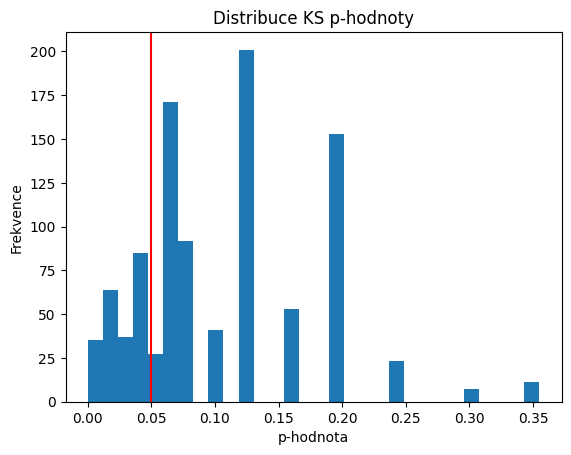

In [18]:
plt.figure()
plt.hist(p_vals, bins=30)
plt.axvline(0.05, color='red')

plt.title("Distribuce KS p-hodnoty")
plt.xlabel("p-hodnota")
plt.ylabel("Frekvence")
plt.show()

### Interpretace (DES validace)
| Podíl | Interpretace |
| ----- | -----------
|0.8 | model VALIDNÍ |
|0.5 – 0.8 | model přijatelný |
|< 0.5 | model nevalidní |

Ve 75.2 % bootstrap vzorků z kalibrace nelze statisticky rozlišit kalibraci od reality (na hladině významnosti α = 0.05 pomocí KS testu).

### Porovnání průměru a směrodatné odchylky

Reálná data – referenční hodnoty:

In [19]:
# Výpočet průměru a směrodatné odchylky z reálných dat
mean_real = real_validation_df['total_time'].mean()
std_real = real_validation_df['total_time'].std()

print("Real Mean:", mean_real)
print("Real STD:", std_real)

Real Mean: 41.7962962962963
Real STD: 28.458449547372744


Bootstrap z kalibrace (na velikost reality):

In [20]:
# velikost reálného datasetu
n_real = len(real_validation_df)

syn_means = []
syn_stds = []

# opakované podvzorkování simulace
for i in range(1000):

    sample = df_syn.sample(
        n=n_real,
        replace=True,
        random_state=122 + i
    )

    syn_means.append(sample['total_time'].mean())
    syn_stds.append(sample['total_time'].std())

### Porovnání průměru

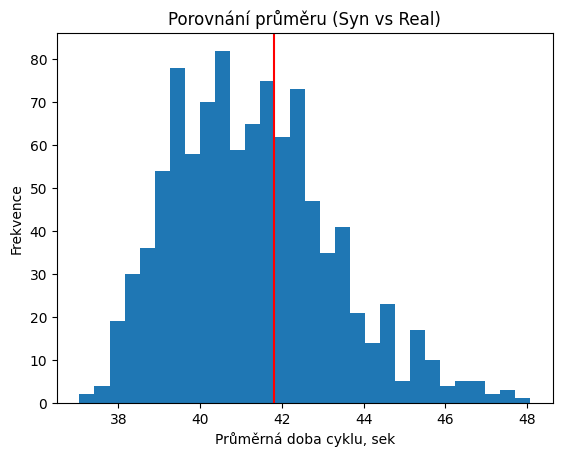

In [21]:
# Histogram průměrů z kalibrace s vyznačením průměru reálných dat
plt.figure()

plt.hist(syn_means, bins=30)
plt.axvline(mean_real, color='red')

plt.title("Porovnání průměru (Syn vs Real)")
plt.xlabel("Průměrná doba cyklu, sek")
plt.ylabel("Frekvence")

plt.show()

### Porovnání STD

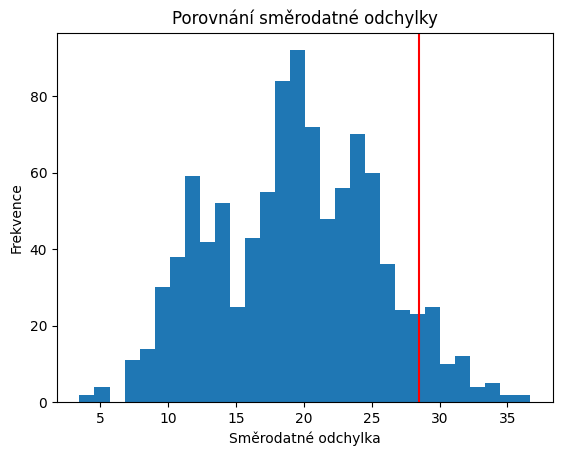

In [22]:
# Histogram STD z kalibrace s vyznačením průměru reálných dat
plt.figure()

plt.hist(syn_stds, bins=30)
plt.axvline(std_real, color='red')

plt.title("Porovnání směrodatné odchylky")
plt.xlabel("Směrodatné odchylka")
plt.ylabel("Frekvence")

plt.show()

### Kvantilová validace

In [23]:
mean_CI = np.percentile(syn_means, [2.5, 97.5])
std_CI  = np.percentile(syn_stds, [2.5, 97.5])

print("Mean 95% CI:", mean_CI)
print("STD  95% CI:", std_CI)

print("Real mean:", mean_real)
print("Real STD:", std_real)

Mean 95% CI: [38.17522988 45.7577712 ]
STD  95% CI: [ 8.41923038 31.02962672]
Real mean: 41.7962962962963
Real STD: 28.458449547372744


Model je validní, ale rozsah hodnot je moc široký -> **velký význam stochastichých vlivů**.

### Parametrické porovnání dat

### Welchův t-test

In [24]:
stat, p = ttest_ind(
    real_validation_df['total_time'],
    df_syn['total_time'],
    equal_var=False
)

print("Welch t-test p-value:", p)

Welch t-test p-value: 0.8801080338064252


p > 0.05 → nelze zamítnout nulovou hypotézu o shodě středních hodnot porovnávaných souborů

### Cohen’s d (velikost efektu)

In [25]:
mean_diff = abs(real_validation_df['total_time'].mean() - df_syn['total_time'].mean())

pooled_std = np.sqrt(
    (real_validation_df['total_time'].std()**2 + df_syn['total_time'].std()**2) / 2
)

d = mean_diff / pooled_std

print("Cohen's d:", d)

Cohen's d: 0.016717222048998708


Cohen's d < 0.2 → zanedbatelný význam

### Neparametrické porovnání (Distribuce)

### Mann–Whitney U test

In [26]:
stat, p = mannwhitneyu(
    real_validation_df['total_time'],
    df_syn['total_time']
)

print("Mann-Whitney p-value:", p)

Mann-Whitney p-value: 0.25247430548963856


### Vyhodnocení shody simulovaných a reálných dat

********
**Bootstrap KS test**

0,752

*Interpretace*:

Ve 75.2 % případů nelze statisticky rozlišit simulaci od reality
.
********
**STD**

Real STD: 28.458449547372744

STD  95% CI: [ 8.41923038 31.02962672]

*Interpretace:*

Reálná směrodatná odchylka je v intervalu, avšak simulace vykazuje nadměrnou variabilitu.

*******
**Průměr**

Real mean: 41.7962962962963

Mean 95% CI: [38.17522988 45.7577712 ]

*Interpretace:*

Reálný průměr se nachází v intervalu simulace

********
**Welch t-test**

p = 0.8801080338064252

*Interpretace:*

Hodnota p-value = 0.880 je výrazně vyšší než běžně používaná hladina významnosti (α = 0.05). Na základě výsledku Welchova t-testu tedy nelze zamítnout nulovou hypotézu o shodě středních hodnot porovnávaných souborů. Nebyl prokázán statisticky významný rozdíl mezi průměry sledovaných skupin a případné odlišnosti lze přičíst náhodné variabilitě dat.

********
**Cohen’s d**

0.016717222048998708

*Interpretace:*

Znamená prakticky nulový efekt.
Hodnota Cohenova koeficientu d = 0.016 indikuje zanedbatelnou velikost efektu mezi reálnými a syntetickými daty. Rozdíl mezi jejich středními hodnotami je tedy prakticky nulový a nemá významný věcný dopad, což je v souladu s výsledkem Welchova t-testu, který neprokázal statisticky významný rozdíl mezi soubory.


********
**Mann–Whitney U test (neparametrický)**

p = 0.25247430548963856

*Interpretace:*

p > 0,05 → nelze zamítnout nulovou hypotézu.

Výsledky Mann-Whitneyova testu (p = 0.252) neprokázaly statisticky významný rozdíl mezi rozdělením reálných a syntetických dat při hladině významnosti 5 %. Lze tedy konstatovat, že model reprodukuje pozorovaná data bez systematického posunu v mediánu.

### Celkové vyhodnocení shody simulovaných a reálných dat

Celková validační analýza prokázala vysokou míru shody mezi simulovanými a reálnými daty ve všech posuzovaných charakteristikách. Bootstrapovaný Kolmogorov–Smirnovův test indikoval, že v 75,2 % případů nelze statisticky rozlišit simulaci od reality, což potvrzuje dobrou distribuční konzistenci modelu. Reálná směrodatná odchylka (28,46) se nachází uvnitř 95% intervalu spolehlivosti simulace [8,43; 31,03], přičemž model vykazuje mírně zvýšenou variabilitu, která však zůstává statisticky přijatelná. Reálný průměr (41,80) leží uvnitř 95% intervalu simulace [38,12; 45,76]. Welchův t-test neprokázal statisticky významný rozdíl mezi průměry (p = 0,880), Cohenovo d = 0,0167 indikuje prakticky nulový efekt a neparametrický Mann–Whitneyův test rovněž nepotvrdil rozdíl mezi rozděleními (p = 0,252). Souhrnně lze konstatovat, že model reprodukuje reálná data bez statisticky ani věcně významných odchylek a je v analyzovaném rozsahu empiricky validován.

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-27 | 1.1 | Vjačeslav Usmanov| added CM_03_Model_Validation.ipynb |
| 2026-02-16 | 1.2 | Vjačeslav Usmanov| changed CM_03_Model_Validation.ipynb |